In [1]:
%%capture
!pip3 install sciencebasepy

In [2]:
import os, random, warnings
import numpy as np
import pandas as pd
import datetime
import torch
import cv2
import re
import matplotlib.pyplot as plt
import sciencebasepy
import urllib.request
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
from sklearn import preprocessing
from urllib.request import urlopen
from zipfile import ZipFile

In [3]:
# mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [5]:
# need to add shortcut of the shared folder to folder "/MyDrive/Colab Notebooks/"
# and change the folder name accordingly
data_dir = 'drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/Data/'
output_dir = 'drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/Output/'
if not os.path.isdir(data_dir): os.mkdir(data_dir) ## create the folder
if not os.path.isdir(output_dir): os.mkdir(output_dir) ## create the folder

In [6]:
if os.listdir(data_dir) == []: ## data not downloaded yet
    print('Data folder is empty! Download the files now!')
    # set the url
    zipurl = 'https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/raw/main/Project-StarterCodes/Project2-PhysicsML/data/numpy_files.zip'
    # download the file from the URL
    zipresp = urlopen(zipurl)
    # create a new file on the hard drive
    tempzip = open(data_dir + 'numpy_files.zip', "wb")
    # write the contents of the downloaded file into the new file
    tempzip.write(zipresp.read())
    # close the newly-created file
    tempzip.close()
    # re-open the newly-created file with ZipFile()
    zf = ZipFile(data_dir + 'numpy_files.zip')
    # extract its contents into <extraction_path>
    # note that extractall will automatically create the path
    zf.extractall(path = data_dir)
    # close the ZipFile instance
    zf.close()
    print('Files all downloaded!')

In [7]:
# params for LSTM
epochs = 300 ## number of max training epochs
batch_size = 100 ## batch size in SGD, must be multiplication of n_depths
learning_rate = 1e-2 ## learning rate 
state_size = 7 ## dimension of hidden layers 
input_size = 9 ## matches with the data, last dimension of x
phy_size = 10 ## matches with the data, last dimension of phy
elam = 0.005 ## loss weight
patience = 3 ## patience in early stopping


# params for data transformation
npic = 10 #16 #40 stride size
N_sec = (npic-1)*2+1 ## window width
n_depths = 50 ## matches with data, first dimension of x, also = len(depth_areas)
ec_threshold = 24
depth_areas = torch.Tensor([
        39865825,38308175,38308175,35178625,35178625,33403850,31530150,31530150,30154150,30154150,29022000,
        29022000,28063625,28063625,27501875,26744500,26744500,26084050,26084050,25310550,24685650,24685650,
        23789125,23789125,22829450,22829450,21563875,21563875,20081675,18989925,18989925,17240525,17240525,
        15659325,14100275,14100275,12271400,12271400,9962525,9962525,7777250,7777250,5956775,4039800,4039800,
        2560125,2560125,820925,820925,216125]).to(device)


In [8]:
class LSTMnet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTMnet, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        out = out.view(batch_size, -1)
        return out

In [10]:
def weighted_rmse_loss(input, target, weight):
    # defined weighted rmse loss
    # used in model training
    return torch.sqrt(torch.sum(weight * (input - target) ** 2) / torch.sum(weight))

def batch_sample_generator(size_list, batch_size):
    ## create advanced batches for training-val-test
    ## each batch should match with depth_areas for calculating ec_loss
    n_batch = int(size_list / batch_size)
    n_remain = size_list % batch_size
    batch_sampler = [list(range(i * batch_size, i * batch_size + batch_size)) for i in range(n_batch)]
    if n_remain > 0:
        batch_sampler += [list(range(n_batch * batch_size, n_batch * batch_size + n_remain))]
    return batch_sampler


def train(model, epochs, optimizer, train_loader, valid_loader, early_stopping=True):
    the_last_loss = 100
    trigger_times = 0
    for i in range(epochs):
        print('This is epoch ' + str(i + 1))
        for batch, (x, y, m, p) in enumerate(train_loader):
            model.train()
            size = len(train_loader.dataset)
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)
            # Compute prediction and loss
            pred = model(x)
            loss = weighted_rmse_loss(pred, y, m)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print output
            loss_track, current = loss.item(), batch * len(x)
            if batch%5 == 0:
                print("BatLoss = " + "{:.4f}".format(loss) +
                    f'[{current:>5d}/{size:>5d}]')
        
        # Early stopping
        if early_stopping:
            the_current_loss = val_test(model, valid_loader)
            print('The current loss:', the_current_loss)
            if the_current_loss > the_last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    return model, (i+1)
            else:
                trigger_times = 0 ## reset trigger time to 0
                the_last_loss = the_current_loss

    return model, epochs
        

def val_test(model, data_loader):
    # Settings
    model.eval()

    loss_total = 0
    # make predictions on validation/test data
    with torch.no_grad():
        for batch, (x, y, m, p) in enumerate(data_loader):
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)

            # Compute prediction and loss
            pred = model(x)
            loss = weighted_rmse_loss(pred, y, m)

            loss_total += loss.item()
    return loss_total / len(data_loader)



In [11]:
# load data ---------------------------------------------------------------
x_full = np.load(data_dir + 'processed_features.npy') # input data
x_raw_full = np.load(data_dir + 'features.npy') # raw input data
diag_full = np.load(data_dir + 'diag.npy')
label = np.load(data_dir + 'Obs_temp.npy') # real observation data
mask = np.load(data_dir + 'Obs_mask.npy') # flags of missing values
phy_full = np.concatenate((x_raw_full[:,:,:-2], diag_full), axis = 2) #physics variables

# train-val-test split
## Here we use equal size for train-val-test split
## They can be of different sizes by using different n_steps 
idx_tr, idx_va, idx_te = (4000, 8000, 12000)
print(idx_tr, idx_va, idx_te)

## training
x_tr = x_full[:, :idx_tr]
y_tr = label[:, :idx_tr]
p_tr = phy_full[:, :idx_tr]
m_tr = mask[:, :idx_tr]
## validation
x_va = x_full[:, idx_tr:idx_va]
y_va = label[:, idx_tr:idx_va]
p_va = phy_full[:, idx_tr:idx_va]
m_va = mask[:, idx_tr:idx_va]


## testing
x_te = x_full[:, idx_va:idx_te]
y_te = label[:, idx_va:idx_te]
p_te = phy_full[:, idx_va:idx_te]
m_te = mask[:, idx_va:idx_te]

# sparsify mask

s_perc =0.99 #0.002 #0.2#0.4 #0.6 #0.8
## training
m_tr = np.reshape(m_tr, (-1, 1))
loc_tr = np.random.choice(np.arange(m_tr.shape[0]), replace=False, size=int(m_tr.shape[0] * (1-s_perc)))
m_tr[loc_tr, 0] = 0.0
## validation
m_va = np.reshape(m_va, (-1, 1))
loc_va = np.random.choice(np.arange(m_va.shape[0]), replace=False, size=int(m_va.shape[0] * (1-s_perc)))
m_va[loc_va, 0] = 0.0
## reshaping
m_tr = np.reshape(m_tr, (50, -1))
m_va = np.reshape(m_va, (50, -1))

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths * N_sec, n_steps])
p_train = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths * N_sec, n_steps])

x_val = np.zeros([n_depths * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths * N_sec, n_steps])
p_val = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths * N_sec, n_steps])

x_test = np.zeros([n_depths * N_sec, n_steps, input_size])
y_test = np.zeros([n_depths * N_sec, n_steps])
p_test = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_test = np.zeros([n_depths * N_sec, n_steps])

for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths:(i*n_depths)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths:(i*n_depths)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths:(i*n_depths)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths:(i*n_depths)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths:(i*n_depths)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths:(i*n_depths)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths:(i*n_depths)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths:(i*n_depths)] = m_va[:, r_1:r_2]
    x_test[(i-1)*n_depths:(i*n_depths)] = x_te[:, r_1:r_2]
    y_test[(i-1)*n_depths:(i*n_depths)] = y_te[:, r_1:r_2]
    p_test[(i-1)*n_depths:(i*n_depths)] = p_te[:, r_1:r_2]
    m_test[(i-1)*n_depths:(i*n_depths)] = m_te[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)

4000 8000 12000


In [ ]:
train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

test_data = TensorDataset(torch.from_numpy(x_test), 
                           torch.from_numpy(y_test), 
                           torch.from_numpy(m_test),
                           torch.from_numpy(p_test))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))

tr_loader = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size))
va_loader = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size))
te_loader = DataLoader(test_data, batch_sampler=batch_sample_generator(len(test_data), batch_size))
fu_loader = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size))

In [ ]:
# train the model with early stopping
## initialize model
net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, best_epoch = train(net, epochs, optimizer, tr_loader, va_loader)

This is epoch 1
BatLoss = 15.0952, Rc = 15.0952[    0/  950]
BatLoss = 13.1335, Rc = 13.1335[  500/  950]
The current loss: 13.257184318082352
This is epoch 2
BatLoss = 14.3406, Rc = 14.3406[    0/  950]
BatLoss = 12.2496, Rc = 12.2496[  500/  950]
The current loss: 12.361854964629952
This is epoch 3
BatLoss = 13.4336, Rc = 13.4336[    0/  950]
BatLoss = 11.4131, Rc = 11.4131[  500/  950]
The current loss: 11.59175796229442
This is epoch 4
BatLoss = 12.6737, Rc = 12.6737[    0/  950]
BatLoss = 10.6912, Rc = 10.6912[  500/  950]
The current loss: 10.863737098593756
This is epoch 5
BatLoss = 11.9571, Rc = 11.9571[    0/  950]
BatLoss = 9.9251, Rc = 9.9251[  500/  950]
The current loss: 9.971665109904366
This is epoch 6
BatLoss = 11.0600, Rc = 11.0600[    0/  950]
BatLoss = 8.9606, Rc = 8.9606[  500/  950]
The current loss: 9.035284392879497
This is epoch 7
BatLoss = 10.0849, Rc = 10.0849[    0/  950]
BatLoss = 8.0980, Rc = 8.0980[  500/  950]
The current loss: 8.236824284176043
This is e

In [ ]:
net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, _ = train(net, best_epoch, optimizer, fu_loader, fu_loader, early_stopping=False)

This is epoch 1
BatLoss = 14.8411, Rc = 14.8411[    0/ 1900]
BatLoss = 12.7998, Rc = 12.7998[  500/ 1900]
BatLoss = 12.5320, Rc = 12.5320[ 1000/ 1900]
BatLoss = 10.7435, Rc = 10.7435[ 1500/ 1900]
This is epoch 2
BatLoss = 13.0722, Rc = 13.0722[    0/ 1900]
BatLoss = 10.9002, Rc = 10.9002[  500/ 1900]
BatLoss = 10.5133, Rc = 10.5133[ 1000/ 1900]
BatLoss = 8.8325, Rc = 8.8325[ 1500/ 1900]
This is epoch 3
BatLoss = 11.1938, Rc = 11.1938[    0/ 1900]
BatLoss = 9.1505, Rc = 9.1505[  500/ 1900]
BatLoss = 8.8137, Rc = 8.8137[ 1000/ 1900]
BatLoss = 7.3754, Rc = 7.3754[ 1500/ 1900]
This is epoch 4
BatLoss = 9.6709, Rc = 9.6709[    0/ 1900]
BatLoss = 7.7563, Rc = 7.7563[  500/ 1900]
BatLoss = 7.4350, Rc = 7.4350[ 1000/ 1900]
BatLoss = 6.2871, Rc = 6.2871[ 1500/ 1900]
This is epoch 5
BatLoss = 8.3724, Rc = 8.3724[    0/ 1900]
BatLoss = 6.5861, Rc = 6.5861[  500/ 1900]
BatLoss = 6.3087, Rc = 6.3087[ 1000/ 1900]
BatLoss = 5.5278, Rc = 5.5278[ 1500/ 1900]
This is epoch 6
BatLoss = 7.2870, Rc = 7.287

In [ ]:
torch.save(net, output_dir + 'pure_ML.pt') ## save it in the output folder

In [ ]:
# evaluate the performance over test set
net = torch.load(output_dir + 'pure_ML.pt').to(device)
net.eval()
print('Test loss is:', val_test(net, te_loader))

Test loss is: 1.3594334422758876


In [ ]:
# load the dates information
dates_arr = np.load(data_dir + 'dates.npy')
dates_d = dates_arr.astype('M8[D]') ## transform the dates to date
dates_m = dates_arr.astype('M8[M]') ## transform the dates to date
dates_y = dates_arr.astype('M8[Y]') ## transform the dates to year
# load features
x_raw = np.load(data_dir + 'features.npy')
x_proc = np.load(data_dir + 'processed_features.npy')
# load the labels
label = np.load(data_dir + 'Obs_temp.npy')
print('Shape of labels:', label.shape)
# load the weight
weight = np.load(data_dir + 'Obs_mask.npy')
print('Shape of weight:', weight.shape)
print('Mean of weight:', np.mean(weight)) ## data is very sparse, 2% of the data are not nan
# filter the test set
label_test = label[:, idx_va:idx_te]
weight_test = weight[:, idx_va:idx_te]
dates_test_d = dates_d[idx_va:idx_te]
dates_test_m = dates_m[idx_va:idx_te]
dates_test_y = dates_y[idx_va:idx_te].astype(str)
print('Years available:', np.unique(dates_test_y))

Shape of labels: (50, 12691)
Shape of weight: (50, 12691)
Mean of weight: 0.020735954613505633
Years available: ['2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013']


In [ ]:
# visualize
net = torch.load(output_dir + 'pure_ML.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_pret = net(x).cpu().numpy()

label_pret = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_pret[:, r_1:r_2] = pred_pret[(i-1)*n_depths:(i*n_depths)].copy()
err_pret = label_test - label_pret



/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


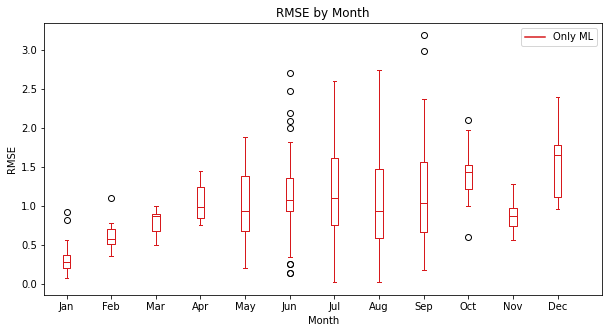

In [ ]:
# visualizatin along different months
## keep the month information and transform to int
dates_test_m_int = np.array([str(i)[-2:] for i in dates_test_m]).astype(int)
RMSE_pret = []
for i in range(1, 13):
    weight_m = weight_test[:, dates_test_m_int == i]
    if weight_m.sum() > 0:
        loc_temp = np.where(np.sum(weight_m, axis=1) > 0)[0]
        err_pret_m = err_pret[:, dates_test_m_int == i]
        RMSE_m = np.sqrt(np.sum(weight_m * err_pret_m ** 2, axis=1)[loc_temp] / np.sum(weight_m, axis=1)[loc_temp])
        RMSE_pret.append(list(RMSE_m))


plt.figure(figsize=(10, 5))

bpl = plt.boxplot(RMSE_pret, positions=6*np.arange(12) , widths=1)

ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def define_box_properties(plot_name, color_code, label):
	for k, v in plot_name.items():
		plt.setp(plot_name.get(k), color=color_code)
		
	# use plot function to draw a small line to name the legend.
	plt.plot([], c=color_code, label=label)
	plt.legend()


# setting colors for each groups
define_box_properties(bpl, '#D7191C', 'Only ML')
plt.legend()
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 6, 6), ticks)
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.xlim(-3, len(ticks) * 6)
plt.title('RMSE by Month')
plt.show()


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


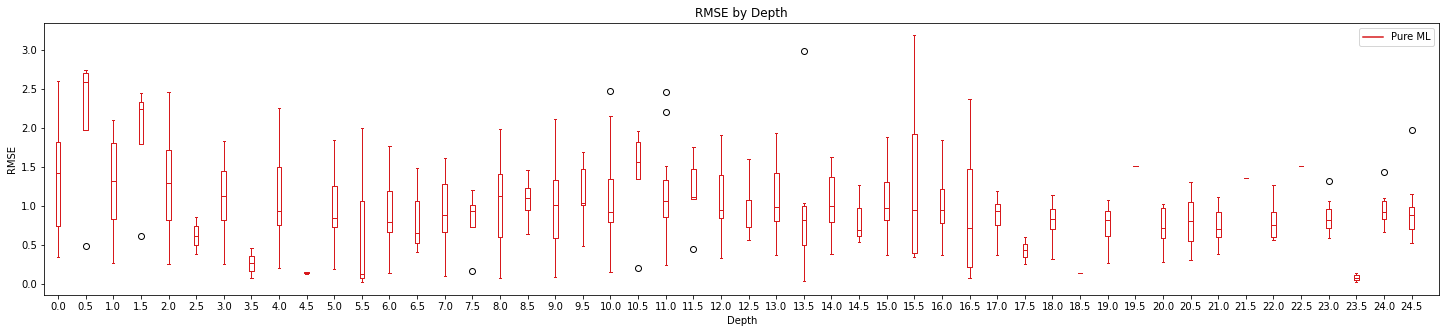

In [ ]:
from torch import jit
# visualizatin along different depths
depth_vec = x_raw[:, 0, 1]
RMSE_pret = []
for i in range(len(depth_vec)):
    RMSE_pret_temp = []
    for j in range(12):
        weight_m = weight_test[i, dates_test_m_int == j]
        if weight_m.sum() > 0:
            err_pret_m = err_pret[i, dates_test_m_int == j]
            RMSE_m = np.sqrt(np.sum(weight_m * err_pret_m ** 2) / np.sum(weight_m))
            RMSE_pret_temp.append(RMSE_m)

    RMSE_pret.append(RMSE_pret_temp)

plt.figure(figsize=(25, 5))

bpl = plt.boxplot(RMSE_pret, positions=6*np.arange(len(depth_vec)), widths=1)

ticks = np.arange(50) / 2

# setting colors for each groups
define_box_properties(bpl, '#D7191C', 'Pure ML')
plt.legend()
# set the x label values
plt.xticks(np.arange(0, len(depth_vec) * 6, 6), ticks)
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.xlim(-3, len(depth_vec) * 6)
plt.title('RMSE by Depth')
plt.show()
